Image Enhancement

Mount Google Drive

Import libraries

Load from Google Drive or Read from url

Add noise to image

Denoise

Edge Detection
* Canny edge
* Laplacian operator
* Sobel operator
* cv2.CV_8U or cv2.CV_64F (set diff data type of image)

1. Mount Google Drive

In [1]:
import io
import requests
from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

2. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io # to read url
from PIL import Image 
import matplotlib.pylab as plt

3. Load from Google Drive or Read from url

In [3]:
# Load from Google Drive.
# DATA_DIR = "/content/gdrive/MyDrive/Colab Notebooks/cameraman.jpg"
# image = cv.imread(DATA_DIR)
# cv_imshow(image)
# cv.waitKey(0)
  
# Or Read from url for public domain images
img = io.imread("https://homepages.cae.wisc.edu/~ece533/images/cameraman.tif") 

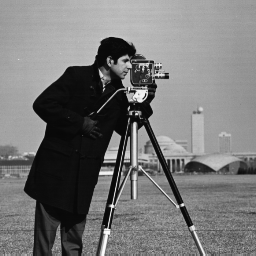

uint8
256
256
(256, 256)


In [4]:
cv2_imshow(img)
# Check the image matrix data type to know the bit depth of the image
# could be either binary (2 parameters / channels) OR rgb in grey shades (3 parameters / channels)
print(img.dtype) # unsigned 8 bit integer

# Check the height of image 
print(img.shape[0])

# Check the width/columns of image 
print(img.shape[1])

# access shape of image to return a tuple of number of rows, columns, and channels
# If image = grayscale, tuple returned contains only number of rows and columns (2 parameters)
print(img.shape)

4. Add noise to image

random_noise

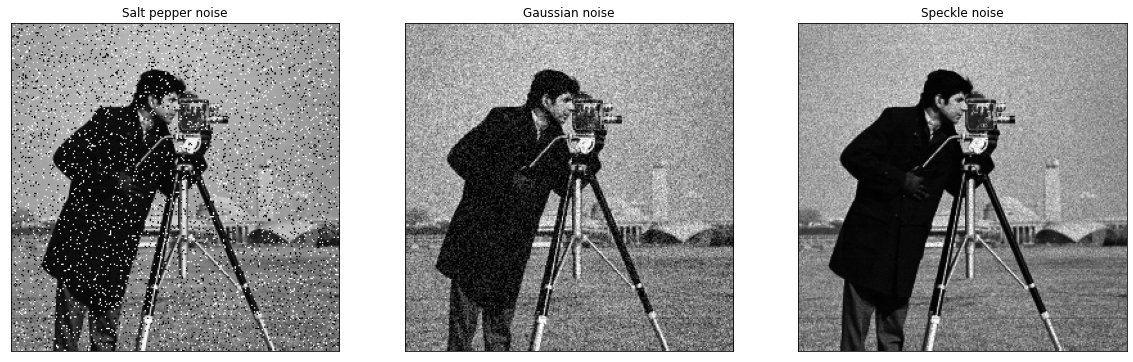

In [5]:
from skimage.util import random_noise
# using opencv functions. mathlab has more functions

# mode is type of noise. 'salt' OR 'pepper' also allowed
# for amount and var, bigger value for 0.05 and 0.1 will mean noisier image

# amount is intensity/concentration of noise to be added. proportion out of whole 
  # image to add noise. default value is 0.05. available for salt, pepper, s&p
sp_img = random_noise(img, mode='s&p',amount=0.05) 

# var is variance of random dist. default is standard deviation. caused by eletronic static
gaussian_img = random_noise(img, mode='gaussian', var=0.1**2) 

speckle_img = random_noise(img, mode='speckle', var=0.1**2) 

# The above function returns a floating-point image in the range [0, 1], 
# to change back to specific data type 'uint8' and from [0,255], perform ori image x 255
sp_img = np.array(255*sp_img, dtype = 'uint8')
gaussian_img = np.array(255*gaussian_img, dtype = 'uint8')
speckle_img = np.array(255*speckle_img, dtype = 'uint8')

# configurations to plot figure

plt.figure(figsize=([20, 20]))

# cmap grey = colour map in grey scale
plt.subplot(131),plt.imshow(sp_img, cmap = 'gray')
plt.title('Salt pepper noise'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(gaussian_img, cmap = 'gray')
plt.title('Gaussian noise'), plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow(speckle_img, cmap = 'gray')
plt.title('Speckle noise'), plt.xticks([]), plt.yticks([])

plt.show()

5. Denoise

cv.fastNlMeansDenoising is used for grey scale images

cv.fastNIMeansDenoisingColoured is used for coloured images

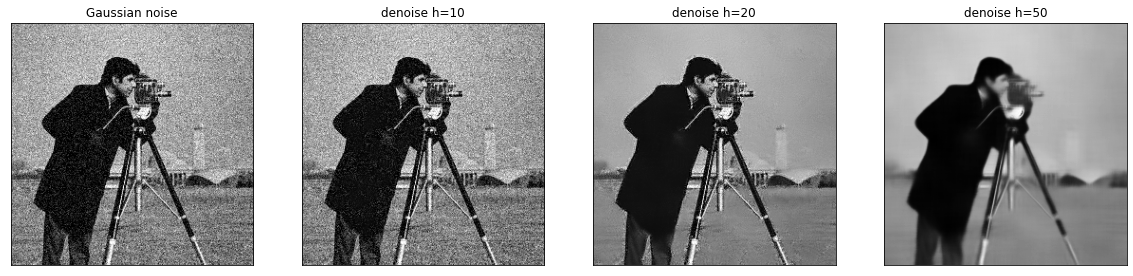

In [ ]:
# none is output image, 10 is strength of filter to remove noise, greater will 
  # remove noise better but will also remove details 
# 7 is template window size in pixels used to compute weights, 21 is search window size 
  # in pixels used to compute weighted average for given pixel. both always odd number
# 10, 7, 21 is optimum, greater will take longer to denoise
denoise_gaussian1 = cv.fastNlMeansDenoising(gaussian_img, None, 10, 7, 21)
denoise_gaussian2 = cv.fastNlMeansDenoising(gaussian_img, None, 20, 7, 21)
denoise_gaussian3 = cv.fastNlMeansDenoising(gaussian_img, None, 50, 7, 21)

plt.figure(figsize=([20, 20]))

plt.subplot(141),plt.imshow(gaussian_img, cmap = 'gray')
plt.title('Gaussian noise'), plt.xticks([]), plt.yticks([])

plt.subplot(142),plt.imshow(denoise_gaussian1, cmap = 'gray')
plt.title('denoise h=10'), plt.xticks([]), plt.yticks([])

plt.subplot(143),plt.imshow(denoise_gaussian2, cmap = 'gray')
plt.title('denoise h=20'), plt.xticks([]), plt.yticks([])

plt.subplot(144),plt.imshow(denoise_gaussian3, cmap = 'gray')
plt.title('denoise h=50'), plt.xticks([]), plt.yticks([])

plt.show()

6. Edge Detection
* detect in parallel or horizontal (parallel edges and horizontal edges)
* identify signature
* identify objects
* need a kernel to detect

6a. Canny Edge Detection

cv.Canny(input_ing, minVal, maxVal)
* function

Canny Edge Detection is a multi-stages algorithm:

1. Noise reduction using 5x5 Gaussian filter
2. Finding Intensity Gradient of the Image
3. Non-maximum Suppression

how to find edges:
* After getting gradient magnitude and direction, a full scan of image is done to remove any unwanted pixels which may not constitute the edge.
* For this, at every pixel, pixel is checked if it is a local maximum in its neighborhood in the direction of gradient. Non-maximum supression

1st image is input, 2nd image is output
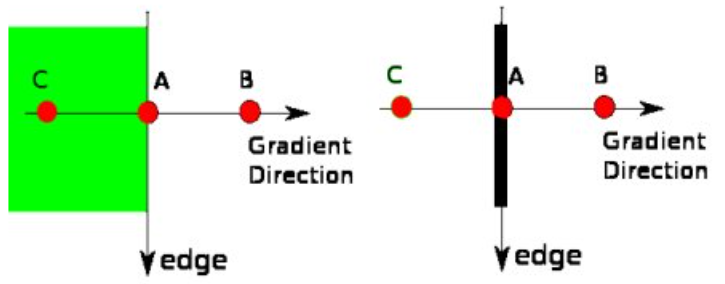
* Point A is on the edge ( in vertical direction). Gradient direction is normal to the edge (at 90 degrees)
* Point B and C are in gradient directions. So point A is checked with point B and C to see if it forms a local maximum.
* If so, it is considered for next stage, otherwise, it is suppressed (put to zero, omitted from operations, like B and C).
* In short, the result you get is a binary image with "thin edges". Vertical edge at A, since A is local maximum.

1. Hysteresis Thresholding
* To determine if all edges are really edges and which are not. For this, we need two threshold values, minVal and maxVal.
* Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity.
* If they are connected to "sure-edge" pixels, they are considered to be part of edges.
* Otherwise, they are also discarded.
 Hysterisis Thresholding
 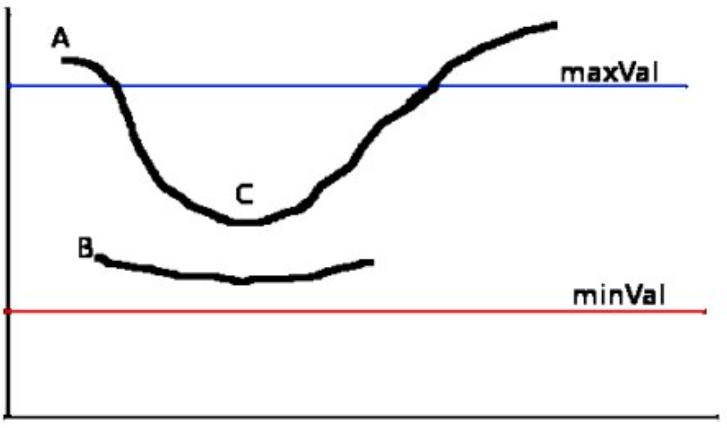
* The edge A is above the maxVal, so considered as "sure-edge".
* Although edge C is below maxVal, it is connected to edge A (pixels are connected/adjacent), so that also considered as valid edge and we get that full curve.
* But edge B, although it is above minVal and is in same region as that of edge C, it is not connected to any "sure-edge", so that is discarded. - So it is very important that we have to select minVal and maxVal accordingly to get the correct result.
* This stage also removes small pixels noises on the assumption that edges are long lines.

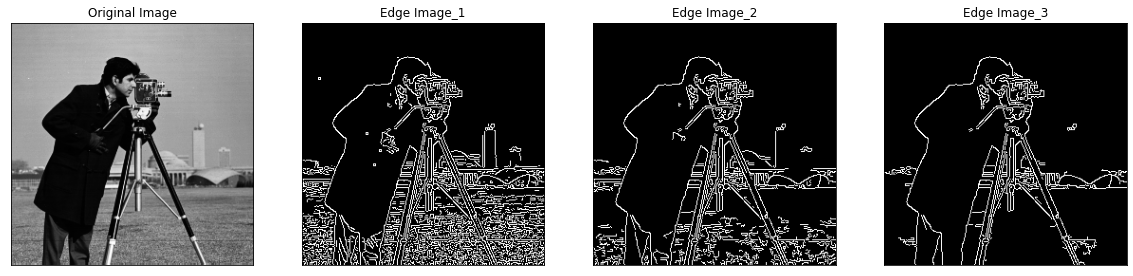

In [ ]:
# min value thresholds are 50, 100, 100
# max value thresholds are 70, 200, 400
edges_1 = cv.Canny(img,50,70)
edges_2 = cv.Canny(img,100,200)
edges_3 = cv.Canny(img,100,400)

plt.figure(figsize=([20, 20]))

plt.subplot(141),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(142),plt.imshow(edges_1,cmap = 'gray')
plt.title('Edge Image_1'), plt.xticks([]), plt.yticks([])

plt.subplot(143),plt.imshow(edges_2,cmap = 'gray')
plt.title('Edge Image_2'), plt.xticks([]), plt.yticks([])

# best, since pebbles, road, and grass not identified
plt.subplot(144),plt.imshow(edges_3,cmap = 'gray')
plt.title('Edge Image_3'), plt.xticks([]), plt.yticks([])
plt.show()

6b. Laplacian & Sobel Operator

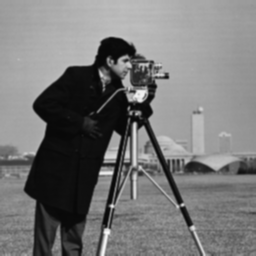

In [ ]:
# Remove noise by blurring with a Gaussian filter

# gaussian kernal size is 3 by 3, can differ but must be positive and odd
imgBlur = cv.GaussianBlur(img,(3,3),0) 
cv2_imshow(imgBlur)

In [ ]:
# convolute with proper kernels

# lapacian operator
laplacian = cv.Laplacian(imgBlur,cv.CV_64F) # image, data type

# sobel operator has horizontal and vertical. ksize = kernal size
sobelx = cv.Sobel(imgBlur,cv.CV_64F,1,0,ksize=5)  # x direction specified through 1, 0
sobely = cv.Sobel(imgBlur,cv.CV_64F,0,1,ksize=5)  # y direction specified through 0, 1

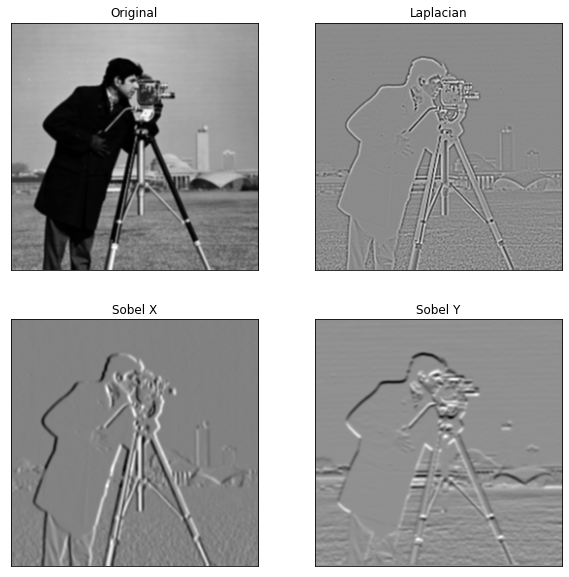

In [ ]:
plt.figure(figsize=([10, 10]))
plt.subplot(2,2,1),plt.imshow(imgBlur,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

cv2.CV_8U or cv2.CV_64F
* different data types

In our last example, output datatype is cv2.CV_8U or np.uint8 (unsigned 8 bits integer. input is this data type as well). But there is a slight problem with that. Black-to-White transition is taken as Positive slope (it has a positive value) while White-to-Black transition is taken as a Negative slope (It has negative value). So when you convert data to np.uint8, all negative slopes are made zero. In simple words, you miss that edge.

If you want to detect both edges (preserve negative slopes), better option is to keep the output datatype to some higher forms and perform operations in this, like cv2.CV_16S, cv2.CV_64F etc, take its absolute value and then convert back to cv2.CV_8U to display image in the form 0 to 255. Below code demonstrates this procedure for a horizontal and vertical Sobel filter/operator and difference in results for different data types.

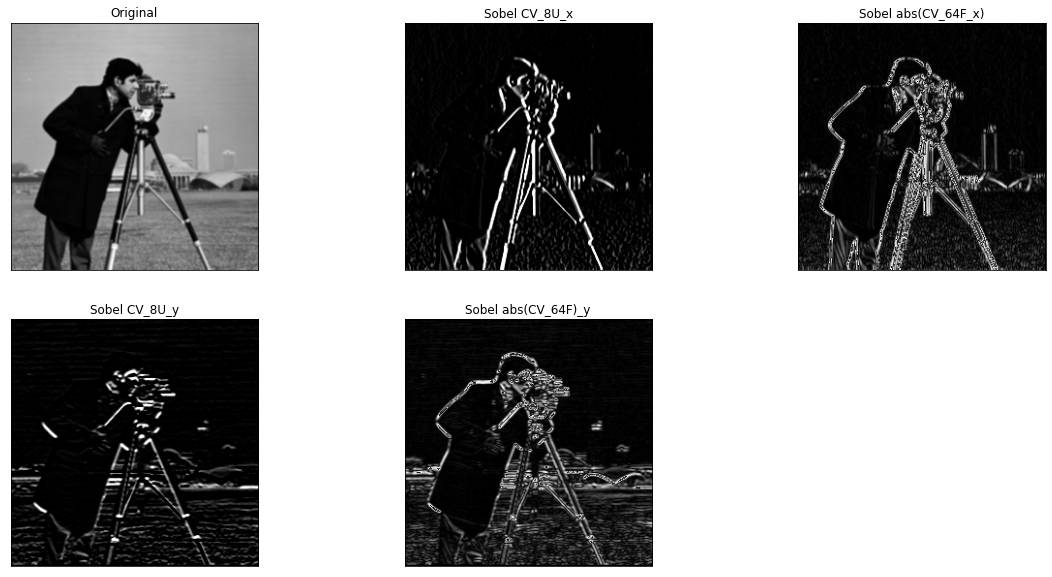

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Output dtype = cv2.CV_8U = unsigned 8 bits integer
sobelx8u_x = cv2.Sobel(imgBlur,cv2.CV_8U,1,0,ksize=3) # x
sobelx8u_y = cv2.Sobel(imgBlur,cv2.CV_8U,0,1,ksize=3) # y

# Output dtype = cv2.CV_64F
sobelx64f_x = cv2.Sobel(imgBlur,cv2.CV_64F,1,0,ksize=3) # x
sobelx64f_y = cv2.Sobel(imgBlur,cv2.CV_64F,0,1,ksize=3) # y
# take absolute value of x and y directions
abs_sobel64f_x = np.absolute(sobelx64f_x)
abs_sobel64f_y = np.absolute(sobelx64f_y)
# convert to cv2.CV_8U unsigned 8 bits integer for x and y directions
sobel_8u_x = np.uint8(abs_sobel64f_x)
sobel_8u_y = np.uint8(abs_sobel64f_y)

# original image
plt.figure(figsize=([20, 10]))
plt.subplot(2,3,1),plt.imshow(imgBlur,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

# unsigned 8 bits in x direction. lost some edges on the left
plt.subplot(2,3,2),plt.imshow(sobelx8u_x,cmap = 'gray')
plt.title('Sobel CV_8U_x'), plt.xticks([]), plt.yticks([])

# in x direction in higher form. preserved some but still lost some edges
plt.subplot(2,3,3),plt.imshow(sobel_8u_x,cmap = 'gray')
plt.title('Sobel abs(CV_64F_x)'), plt.xticks([]), plt.yticks([])

# unsigned 8 bits in y direction. lost some edges, more than that in x direction
plt.subplot(2,3,4),plt.imshow(sobelx8u_y,cmap = 'gray')
plt.title('Sobel CV_8U_y'), plt.xticks([]), plt.yticks([])

# in y direction in higher form. preserved some but still lost some edges, 
  # better than that in x direction
plt.subplot(2,3,5),plt.imshow(sobel_8u_y,cmap = 'gray')
plt.title('Sobel abs(CV_64F)_y'), plt.xticks([]), plt.yticks([])

plt.show()